In [120]:
import pandas as pd
import numpy as np
import tqdm
from tqdm import tqdm_notebook
import difflib
import sys
import re
from matplotlib import pyplot as plt
import matplotlib

import ast
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import SnowballStemmer 
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize

from pymystem3 import Mystem
YStem = Mystem()

%pylab inline

from sklearn.ensemble import GradientBoostingClassifier

import scipy
from scipy import spatial

Populating the interactive namespace from numpy and matplotlib


## Step 1

In [58]:
tr, tt = pd.read_csv("train_tokens_facts_number.csv"), pd.read_csv("test_tokens_facts_number.csv")

In [59]:
tr.head()

,paragraph,paragraph_id,question,question_id,target,train,tokens_paragraph,tokens_question,facts_paragraph,facts_question,cosine_distance,len_paragraph,len_question,len_intersection,len_intersection_rate,terms_paragraph,terms_question,terms_intersection,terms_intersection_rate
0,"В отличие от рыб, земноводные (амфибии) и прес...",1094,С какого года Русское Царство перешло на летои...,46273,0.0,1,"['в', 'отличие', 'от', 'рыба', 'земноводный', ...","['с', 'какой', 'год', 'русский', 'царство', 'п...","['сердце', 'четырёхкамерный сердце', 'рептилия...","['год', 'русский царство', 'какая год', '1 янв...",0.982397,64,19,4,0.210526,40,12,0,0.000000
1,В 1049 году Балдуину V удалось отнять у Герман...,7414,Кто упомянул о его первых разногласиях со Штей...,19164,0.0,1,"['в', '1049', 'год', 'балдуин', 'v', 'удаться'...","['кто', 'упомянуть', 'о', 'он', 'один', 'разно...","['балдуин', 'сын', 'граф', 'фландрий', 'престо...","['подозрительный модернистский наклонность', '...",0.970422,78,29,4,0.137931,34,14,0,0.000000
2,Стремление достичь предельных значений ёмкости...,6744,Как называется имеющая мировое значение эпоха ...,39767,0.0,1,"['стремление', 'достигнуть', 'предельный', 'зн...","['как', 'называться', 'иметь', 'мировой', 'зна...","['страница', 'информация', 'блок', 'одиночный ...","['средний веко', 'новый время', 'мировая значе...",0.944973,58,20,5,0.250000,37,12,1,0.083333
3,Первый практически пригодный двухтактный газов...,7300,Что усугублялось из-за международного давления...,36318,0.0,1,"['один', 'практически', 'пригодный', 'двухтакт...","['что', 'усугубляться', 'из', 'за', 'междунаро...","['двигатель', 'ленуар', 'электрический искрово...","['международный давление', 'чили', 'торговля',...",0.985656,62,14,3,0.214286,37,7,0,0.000000
4,Требуя от художника углубленного изучения изоб...,7077,Какой характер носят пророчества Леонардо да В...,41534,0.0,1,"['требовать', 'от', 'художник', 'углублённый',...","['какой', 'характер', 'носить', 'пророчество',...","['книжка', 'запись', 'своеобразный интимный дн...","['какая характер', 'характер', 'пророчество', ...",0.831019,83,7,4,0.571429,48,5,2,0.400000


In [69]:
tr.paragraph[0]

'В отличие от рыб, земноводные (амфибии) и пресмыкающиеся (рептилии или гады) уже имеют два круга кровообращения и сердце у них трёхкамерное (появляется межпредсердная перегородка). Единственные современные рептилии, имеющие хотя и неполноценное (межпредсердиевая перегородка не полностью разделяет предсердия, что скорей всего связано с переходом предков к полуводному образу жизни и снижению активности), но уже четырёхкамерное сердце — крокодилы. Считается, что впервые четырёхкамерное сердце появилось у примитивных архозавров и развитых синапсидов. В дальнейшем такое строение сердца унаследовали прямые потомки динозавров — птицы и потомки примитивных млекопитающих — современные млекопитающие.'

In [70]:
import ast

In [71]:
tr.tokens_paragraph[0]

"['в', 'отличие', 'от', 'рыба', 'земноводный', 'амфибия', 'и', 'пресмыкаться', 'рептилия', 'или', 'гад', 'уже', 'иметь', 'два', 'круг', 'кровообращение', 'и', 'сердце', 'у', 'они', 'трёхкамерный', 'появляться', 'межпредсердный', 'перегородка', 'единственный', 'современный', 'рептилия', 'иметь', 'хотя', 'и', 'неполноценный', 'межпредсердиевый', 'перегородка', 'не', 'полностью', 'разделять', 'предсердие', 'что', 'скорый', 'всего', 'связать', 'с', 'переход', 'предок', 'к', 'полуводный', 'образ', 'жизнь', 'и', 'снижение', 'активность', 'но', 'уже', 'четырёхкамерный', 'сердце', 'крокодил', 'считаться', 'что', 'впервые', 'четырёхкамерный', 'сердце', 'появиться', 'у', 'примитивный', 'архозавр', 'и', 'развитый', 'синапсид', 'в', 'дальнейший', 'такой', 'строение', 'сердце', 'унаследовать', 'прямая', 'потомок', 'динозавр', 'птица', 'и', 'потомок', 'примитивный', 'млекопитающее', 'современный', 'млекопитающее']"

In [66]:
train, test = pd.read_csv("train_task1_latest.csv"), pd.read_csv("test_task1_latest.csv")

In [134]:
common_questions = list(set(train.question)&set(test.question))

In [135]:
common_questions

['Где находится копулятивный орган самцов змей?',
 'Чем контролируется яркая окраска крыльев некоторых бабочек?',
 'Когда возникли взаимовыгодные взаимоотношения пчёл и орхидей?',
 'Что прилипает к голове или груди самца во время посещения цветка?',
 'Кому подражает парусник Papilio agestor?',
 'Что такое АТФ?',
 'Кто опыляет инжир?']

In [136]:
def FormCommonPQList():    
    p_train_list = []
    q_train_list = []
    p_test_list = []
    q_test_list = []
    
    for i in common_questions:    
        if i in list(train.question.values):
            #print(i)
            #p_train_list.append(train[train.question == i].paragraph_id.values)
            #q_train_list.append(train[train.question == i].question_id.values)

            p_test_list.append(test[test.question == i].paragraph_id.values)
            q_test_list.append(test[test.question == i].question_id.values)

    #pq_train_flat_list = list(map(lambda x: [x[0],x[1]], list(zip([item for sublist in p_train_list for item in sublist],[item for sublist in q_train_list for item in sublist]))))
    pq_test_flat_list = list(map(lambda x: [x[0],x[1]], list(zip([item for sublist in p_test_list for item in sublist],[item for sublist in q_test_list for item in sublist]))))
    return pq_test_flat_list

In [137]:
pq_test_flat_list = FormCommonPQList()

In [138]:
#[array([39412], dtype=int64),
# array([29322], dtype=int64),
# array([82264], dtype=int64),
# array([33869], dtype=int64),
# array([12243, 12243], dtype=int64),
# array([17947, 17947], dtype=int64),
# array([92834], dtype=int64)]
pq_test_flat_list

[[606, 30228],
 [609, 17357],
 [241, 18678],
 [241, 4958],
 [906, 4958],
 [1164, 4958],
 [1353, 4958],
 [793, 4958],
 [657, 4958],
 [633, 4958],
 [671, 12468],
 [720, 11863],
 [241, 19513]]

In [139]:
def PrintCommonPQ():
    for index, row in tqdm.tqdm_notebook(test.iterrows(), total=test.shape[0], desc="Searching:"):
        for pq in pq_test_flat_list:
            if (pq[0] == row.paragraph_id) and (pq[1] == row.question_id):
                print(row.paragraph_id,':', row.paragraph)
                print(row.question_id,':', row.question)
                print('-'*100)

CommonPQTargets = [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# (241, 19513): 1.0
# (671, 12468): 1.0
# (241, 4958): 1.0 
# (906, 4958): 0.0 
# (1164, 4958): 0.0
# (1353, 4958): 0.0
# (606, 30228): 0.0
# (793, 4958): 0.0 
# (241, 18678): 1.0
# (657, 4958): 0.0 
# (720, 11863): 1.0
# (633, 4958): 0.0 
# (609, 17357): 0.0

In [140]:
#PrintCommonPQ()

In [141]:
def SetTargetToCommonPQ(test):
    pq_test_flat_list = FormCommonPQList()
    for index, row in tqdm.tqdm_notebook(test.iterrows(), total=test.shape[0], desc="Setting Answers to test.prediction"):
        for i in range(len(pq_test_flat_list)):
            if (pq_test_flat_list[i][0] == row.paragraph_id) and (pq_test_flat_list[i][1] == row.question_id):
                test.loc[index, 'prediction'] = CommonPQTargets[i]

In [142]:
#print(FormCommonPQList())

In [143]:
train.paragraph[0]

'В отличие от рыб, земноводные (амфибии) и пресмыкающиеся (рептилии или гады) уже имеют два круга кровообращения и сердце у них трёхкамерное (появляется межпредсердная перегородка). Единственные современные рептилии, имеющие хотя и неполноценное (межпредсердиевая перегородка не полностью разделяет предсердия, что скорей всего связано с переходом предков к полуводному образу жизни и снижению активности), но уже четырёхкамерное сердце — крокодилы. Считается, что впервые четырёхкамерное сердце появилось у примитивных архозавров и развитых синапсидов. В дальнейшем такое строение сердца унаследовали прямые потомки динозавров — птицы и потомки примитивных млекопитающих — современные млекопитающие.'

In [144]:
train.question[0]

'С какого года Русское Царство перешло на летоисчисление от Рождества Христова и празднование Нового года 1 января, а не 1 сентября?'

In [145]:
def is_uppercase(word):
    if word[0] in list('АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫБЭЮЯ'):
        return True
    else:
        return False

In [146]:
is_uppercase('Просто текст')

True

In [147]:
import pymorphy2 as pm
morph = pm.MorphAnalyzer()
morph.parse('Фредерик Шопена')[0].normal_form

ImportError: No module named 'pymorphy2'

In [26]:
# df - train dataset;
# variable = переменная
# variable_title - название переменной на графике
def PlotHistByTarget(variable, variable_title, min_x, max_x, df, df_title): 
    print('Histogram for '+variable_title)
    
    print(DescStatsByTarget(variable, variable_title, df, df_title))
    
    plt.style.use('seaborn-deep')
    
    if df_title == 'train':
        hist_df = pd.DataFrame({'target':df['target'],variable_title:variable})
        pyplot.hist([hist_df[hist_df['target']==0][variable_title].values,hist_df[hist_df['target']==1][variable_title].values], 
                bins = 100, 
                alpha = 0.5, 
                label=['target: 0','target: 1'], 
                color = ['r','b'])
        plt.xlim(xmin=min_x, xmax = max_x)
        plt.legend()
        plt.show()
    else:
        hist_df = pd.DataFrame({variable_title:variable})
        pyplot.hist(hist_df[variable_title].values, 
                bins = 100, 
                alpha = 0.5, 
                label = 'test dataset',
                color = 'g')
        plt.xlim(xmin=min_x, xmax = max_x)
        plt.legend()
        plt.show()
        
    
def DescStatsByTarget(variable, variable_title, df, df_title):
    
    if df_title == 'train':
        dft = pd.DataFrame({'target':df['target'],variable_title:variable})

        x = dft[dft['target']==0][variable_title].values
        dfx = pd.DataFrame({'target: 0':x})

        count0 = len(x)
        mean0 = round(np.mean(x),6)
        std0 = round(np.std(x),6)
        min0 = round(np.min(x),6)
        median0 = round(np.median(x),6)
        max0 = round(np.max(x),6)

        y = dft[dft['target']==1][variable_title].values
        dfy = pd.DataFrame({'target: 1':y})

        count1 = len(y)
        mean1 = round(np.mean(y),6)
        std1 = round(np.std(y),6)
        min1 = round(np.min(y),6)
        median1 = round(np.median(y),6)
        max1 = round(np.max(y),6)

        df_desc = pd.DataFrame([[count0, mean0, std0, min0, median0, max0],
                            [count1, mean1, std1, min1, median1, max1]],
                            columns = ['count','mean','std','min','median','max'], 
                            index=[variable_title+' (target: 0)',variable_title+' (target: 1)'])
    else:
        
        dft = pd.DataFrame({variable_title:variable})

        x = dft[variable_title].values
        
        count = len(x)
        mean = round(np.mean(x),6)
        std = round(np.std(x),6)
        min = round(np.min(x),6)
        median = round(np.median(x),6)
        max = round(np.max(x),6)

        df_desc = pd.DataFrame([[count, mean, std, min, median, max]],
                            columns = ['count','mean','std','min','median','max'], 
                            index=[variable_title+' (test)'])
    
    return df_desc

In [73]:
def uniq_words(text):
    return set(re.findall("\w+", text))

In [150]:
for name, df in [('train', train), ('test', test)]:
    df.set_value(0,'list_ratio',0)
    df.set_value(0,'list_intersections',0)
    df['list_ratio'] = df['list_ratio'].astype(object)
    df['list_intersections'] = df['list_intersections'].astype(object)
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total=df.shape[0], desc="build features for " + name):
        sentences = row.paragraph.split('. ')
        question = row.question
        
        unq_question = uniq_words(row.question)
        
        list_ratio = []
        list_intersections = []
        
        for sentence in sentences:
            list_ratio.append(round(difflib.SequenceMatcher(None, sentence, question).ratio(),5))
            list_intersections.append(len(uniq_words(sentence) & unq_question))
        
        df.set_value(index, 'list_ratio', list_ratio)
        df.set_value(index, 'list_intersections', list_intersections)
        df.loc[index, 'len_paragraph'] = len(uniq_words(row.paragraph))
        df.loc[index, 'len_question'] = len(unq_question)
        df.loc[index, 'len_intersection'] = len(uniq_words(row.paragraph) & unq_question)

In [151]:
train.to_csv("train_step1.csv", index=False, encoding = 'utf-8')
test.to_csv("test_step1.csv", index=False, encoding = 'utf-8')

train, test = pd.read_csv("train_step1.csv", encoding ='utf-8'), pd.read_csv("test_step1.csv", encoding ='utf-8')

## Step 2

In [153]:
texts = list(train['paragraph'])+list(train['question'])+list(test['paragraph'])+list(test['question'])

wd = {}

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokens = [i.lower() for i in tokens if ( i not in string.punctuation+'—' )]
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на'])
    tokens = [i for i in tokens if ( i not in stop_words )]
    stems = []
    for item in tokens:
        if item in wd.keys():
            stems.append(wd[item])
        else:
            w = SnowballStemmer(language='russian').stem(item)
            wd[item] = w
            stems.append(w)
    return stems

In [154]:
Vectorizer = CountVectorizer(tokenizer=tokenize)
%time Vectorizer.fit(texts)
%time train_p = Vectorizer.transform(train['paragraph'])
%time train_q = Vectorizer.transform(train['question'])
%time test_p =  Vectorizer.transform(test['paragraph'])
%time test_q =  Vectorizer.transform(test['question'])

Wall time: 9min 33s
Wall time: 4min 20s
Wall time: 1min 12s
Wall time: 2min 58s
Wall time: 50 s


In [155]:
from scipy import sparse
tfidf = TfidfTransformer(smooth_idf=False,sublinear_tf=False)
stk = sparse.vstack([train_p,train_q,test_p,test_q])
tfidf.fit(stk)

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [156]:
from sklearn.metrics.pairwise import paired_cosine_distances
dist_train = paired_cosine_distances(tfidf.transform(train_p),tfidf.transform(train_q))
dist_test = paired_cosine_distances(tfidf.transform(test_p),tfidf.transform(test_q))

In [157]:
train['cos_dist'] = dist_train
test['cos_dist'] = dist_test

In [158]:
train.to_csv("train_step2.csv", index=False, encoding = 'utf-8')
test.to_csv("test_step2.csv", index=False, encoding = 'utf-8')

trainf, testf = pd.read_csv("train_step2.csv", encoding ='utf-8'), pd.read_csv("test_step2.csv", encoding ='utf-8')

## Step 3

In [162]:
for name, df in [('train', trainf), ('test', testf)]:
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total=df.shape[0], desc="build features for " + name):
        df.loc[index, 'min_ratio'] = np.min(ast.literal_eval(row.list_ratio))
        df.loc[index, 'max_ratio'] = np.max(ast.literal_eval(row.list_ratio))
        df.loc[index, 'std_ratio'] = np.std(ast.literal_eval(row.list_ratio))
        df.loc[index, 'mean_ratio'] = np.mean(ast.literal_eval(row.list_ratio))
        df.loc[index, 'num_sentences'] = len(ast.literal_eval(row.list_ratio))
        #df.loc[index, 'min_inter'] = np.min(ast.literal_eval(row.list_intersections))
        df.loc[index, 'max_inter'] = np.max(ast.literal_eval(row.list_intersections))

In [164]:
trainf.to_csv("train_step3.csv", index=False, encoding ='utf-8')
testf.to_csv("test_step3.csv", index=False, encoding ='utf-8')

## Step 4

In [144]:
trainf, testf = pd.read_csv("train_step3.csv", encoding ='utf-8'), pd.read_csv("test_step3.csv", encoding ='utf-8')

In [145]:
texts = str(set(list(trainf.paragraph)+ list(trainf.question)+list(testf.paragraph)))

In [146]:
def get_tokens_bigrams(text):
    tokens = nltk.word_tokenize(text)
    tokens = [re.sub('\'','',i.lower()) for i in tokens if ( i not in string.punctuation+'—' )]
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на'])
    tokens = [i for i in tokens if ( i not in stop_words )]
    finder = BigramCollocationFinder.from_words(tokens, window_size=2)
    return finder.nbest(bigram_measures.pmi, 100)

In [147]:
def get_tokens_trigrams(text):
    tokens = nltk.word_tokenize(text)
    tokens = [re.sub('\'','',i.lower()) for i in tokens if ( i not in string.punctuation+'—' )]
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на'])
    tokens = [i for i in tokens if ( i not in stop_words )]
    finder = TrigramCollocationFinder.from_words(tokens, window_size=3)
    return finder.nbest(trigram_measures.pmi, 100)

In [148]:
# Set Bigrams&Trigrams intersection:
for name, df in [('train', trainf), ('test', testf)]:
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total = df.shape[0], desc = "Adding n-grams for "+ name):
        df.loc[index, 'bigram_intersection'] = len(set(list(get_tokens_bigrams(row.paragraph)))&set(list(get_tokens_bigrams(row.question))))
        df.loc[index, 'trigram_intersection'] = len(set(list(get_tokens_trigrams(row.paragraph)))&set(list(get_tokens_trigrams(row.question))))

In [149]:
trainf.to_csv("train_step4.csv", index=False, encoding ='utf-8')
testf.to_csv("test_step4.csv", index=False, encoding ='utf-8')

# Step 5

In [441]:
trainf, testf = pd.read_csv("train_step4.csv", encoding ='utf-8'), pd.read_csv("test_step4.csv", encoding ='utf-8')

In [442]:
for name, df in [('train', trainf), ('test', testf)]:
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total = df.shape[0], desc = "Unique question words "+ name):
        tokens = nltk.word_tokenize(row.question)
        tokens = [re.sub('\'','',i.lower()) for i in tokens if ( i not in string.punctuation+'—' )]
        df.loc[index, 'unq_qwords_rate'] = len(set(tokens))/len(tokens)

In [443]:
trainf.to_csv("train_step5.csv", index=False, encoding ='utf-8')
testf.to_csv("test_step5.csv", index=False, encoding ='utf-8')

In [7]:
trainf, testf = pd.read_csv("train_step5.csv", encoding ='utf-8'), pd.read_csv("test_step5.csv", encoding ='utf-8')

# Step 6

In [ ]:
df.loc[index, 'len_percent'] =  round((len(set(ast.literal_eval(row.tokens_paragraph)+
            ast.literal_eval(row.tokens_question)))/
          len(set(ast.literal_eval(row.tokens_paragraph)))-1)*100,4)

In [ ]:
for name, df in [('train', train), ('test', test)]:
    df.set_value(0,'list_len_percent',0)
    df['list_len_percent'] = df['list_len_percent'].astype(object)
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total=df.shape[0], desc="build features for " + name):
        sentences = row.paragraph.split('. ')

        list_len_percent = []
        
        for sentence in sentences:
            list_len_percent.append(round((len(set(ast.literal_eval(row.tokens_paragraph)+
            ast.literal_eval(row.tokens_question)))/
          len(set(ast.literal_eval(row.tokens_paragraph)))-1)*100,4))

# Graphs

In [ ]:
PlotHistByTarget(trainf.len_question, 'len_question', 0, 40, trainf, 'train')
PlotHistByTarget(testf.len_question, 'len_question', 0, 40, testf, 'test')

In [1]:
PlotHistByTarget(trainf.len_paragraph, 'len_paragraph', 40, 200, trainf, 'train')
PlotHistByTarget(testf.len_paragraph, 'len_paragraph', 40, 200, testf, 'test')

NameError: name 'PlotHistByTarget' is not defined

In [ ]:
PlotHistByTarget(trainf.len_intersection, 'len_intersection', 0, 15, trainf, 'train')
PlotHistByTarget(testf.len_intersection, 'len_intersection', 0, 15, testf, 'test')

Histogram for min_ratio
                       count      mean       std  min   median      max
min_ratio (target: 0)  85361  0.110002  0.063889  0.0  0.12017  0.35345
min_ratio (target: 1)  34037  0.131520  0.068175  0.0  0.13506  0.97398


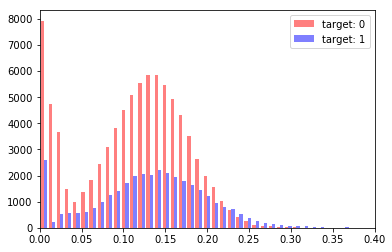

Histogram for min_ratio
                  count      mean       std  min  median      max
min_ratio (test)  74294  0.124086  0.073768  0.0  0.1327  0.98094


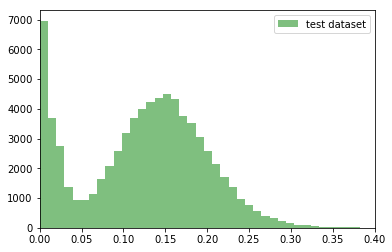

In [28]:
var_title = 'min_ratio' 
PlotHistByTarget(trainf.min_ratio, var_title, 0, 0.4, trainf, 'train')
PlotHistByTarget(testf.min_ratio, var_title, 0, 0.4, testf, 'test')

Histogram for max_ratio
                       count      mean       std      min  median      max
max_ratio (target: 0)  85361  0.269191  0.076324  0.00510  0.2766  0.83333
max_ratio (target: 1)  34037  0.429532  0.180929  0.02071  0.3871  0.99145


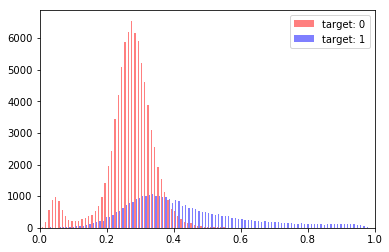

Histogram for max_ratio
                  count      mean      std  min   median      max
max_ratio (test)  74294  0.344035  0.13786  0.0  0.32787  0.99174


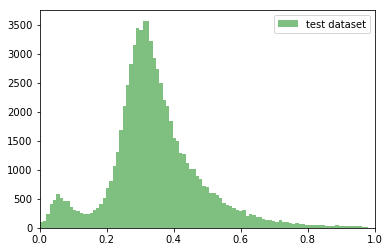

In [29]:
var_title = 'max_ratio' 
PlotHistByTarget(trainf.max_ratio, var_title, 0, 1, trainf, 'train')
PlotHistByTarget(testf.max_ratio, var_title, 0, 1, testf, 'test')

Histogram for std_ratio
                       count      mean       std  min    median       max
std_ratio (target: 0)  85361  0.055267  0.026044  0.0  0.053419  0.252462
std_ratio (target: 1)  34037  0.103941  0.063265  0.0  0.090241  0.450137


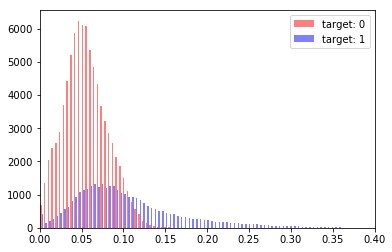

Histogram for std_ratio
                  count      mean       std  min    median       max
std_ratio (test)  74294  0.075219  0.044464  0.0  0.067267  0.434156


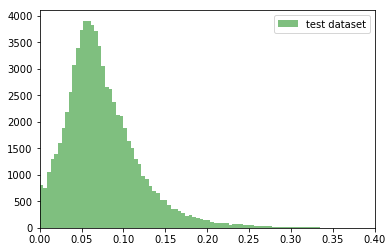

In [31]:
var_title = 'std_ratio' 
PlotHistByTarget(trainf.std_ratio, var_title, 0, 0.4, trainf, 'train')
PlotHistByTarget(testf.std_ratio, var_title, 0, 0.4, testf, 'test')

Histogram for mean_ratio
                        count      mean       std      min    median       max
mean_ratio (target: 0)  85361  0.191673  0.054721  0.00255  0.199163  0.429312
mean_ratio (target: 1)  34037  0.249552  0.069220  0.02071  0.245534  0.973980


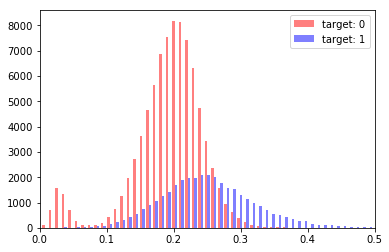

Histogram for mean_ratio
                   count     mean       std  min    median      max
mean_ratio (test)  74294  0.22189  0.075063  0.0  0.227771  0.98094


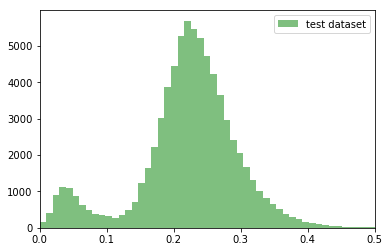

In [32]:
var_title = 'mean_ratio' 
PlotHistByTarget(trainf.mean_ratio, var_title, 0, 0.5, trainf, 'train')
PlotHistByTarget(testf.mean_ratio, var_title, 0, 0.5, testf, 'test')

Histogram for num_sentences
                           count      mean       std  min  median   max
num_sentences (target: 0)  85361  5.978608  2.415787  1.0     5.0  40.0
num_sentences (target: 1)  34037  5.745101  2.993409  1.0     5.0  73.0


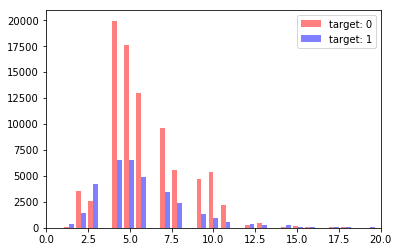

Histogram for num_sentences
                      count      mean       std  min  median   max
num_sentences (test)  74294  6.469728  3.482152  1.0     6.0  32.0


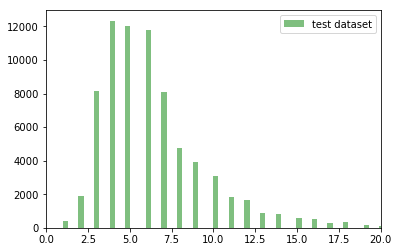

In [33]:
var_title = 'num_sentences' 
PlotHistByTarget(trainf.num_sentences, var_title, 0, 20, trainf, 'train')
PlotHistByTarget(testf.num_sentences, var_title, 0, 20, testf, 'test')

Histogram for min_inter
                       count      mean       std  min  median   max
min_inter (target: 0)  85361  0.226977  0.499684  0.0     0.0   7.0
min_inter (target: 1)  34037  0.253959  0.934635  0.0     0.0  53.0


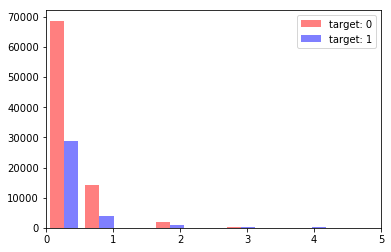

Histogram for min_inter
                  count      mean       std  min  median   max
min_inter (test)  74294  0.303403  0.877877  0.0     0.0  62.0


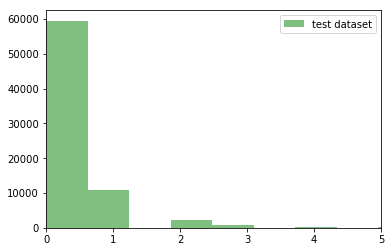

In [34]:
var_title = 'min_inter' 
PlotHistByTarget(trainf.min_inter, var_title, 0, 5, trainf, 'train')
PlotHistByTarget(testf.min_inter, var_title, 0, 5, testf, 'test')

Histogram for max_inter
                       count      mean       std  min  median   max
max_inter (target: 0)  85361  2.449163  0.767937  1.0     2.0  12.0
max_inter (target: 1)  34037  5.170256  3.970357  0.0     4.0  58.0


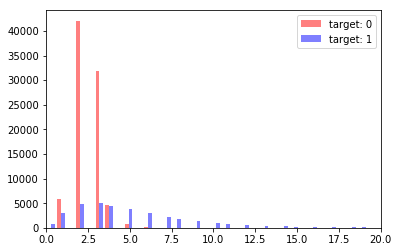

Histogram for max_inter
                  count      mean       std  min  median   max
max_inter (test)  74294  4.181697  2.648538  0.0     3.0  62.0


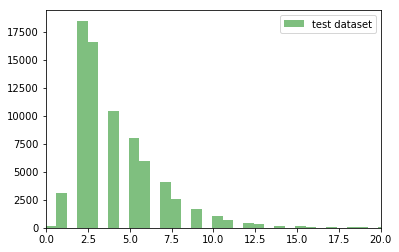

In [35]:
var_title = 'max_inter' 
PlotHistByTarget(trainf.max_inter, var_title, 0, 20, trainf, 'train')
PlotHistByTarget(testf.max_inter, var_title, 0, 20, testf, 'test')

Histogram for bigram_question
                             count      mean       std  min  median   max
bigram_question (target: 0)  85361  0.047914  0.250771  0.0     0.0   8.0
bigram_question (target: 1)  34037  2.535447  3.065821  0.0     2.0  51.0


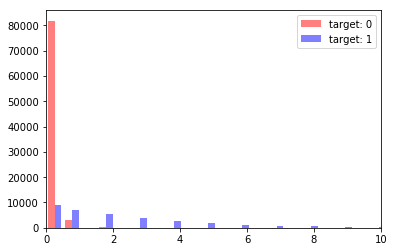

Histogram for bigram_question
                        count      mean       std  min  median   max
bigram_question (test)  74294  1.746251  2.418011  0.0     1.0  61.0


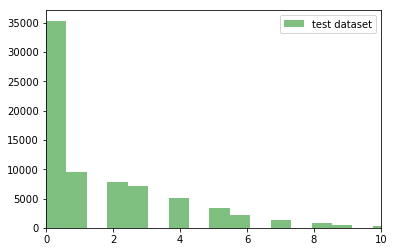

In [152]:
PlotHistByTarget(trainf.bigram_intersection, 'bigram_intersection', 0, 10, trainf, 'train')
PlotHistByTarget(testf.bigram_intersection, 'bigram_intersection', 0, 10, testf, 'test')

In [16]:
trainf[(trainf.trigram_intersection==51)&(trainf.target==1)]

,paragraph_id,question_id,paragraph,question,target,list_ratio,list_intersections,len_paragraph,len_question,len_intersection,...,min_ratio,max_ratio,std_ratio,mean_ratio,num_sentences,min_inter,max_inter,bigram_intersection,trigram_intersection,unq_qwords_rate
42274,2413,8372,Операционный риск — риск возникновения убытков...,Как называется риск возникновения убытков в ре...,1.0,[0.97398],[53],54.0,55.0,53.0,...,0.97398,0.97398,0.0,0.97398,1.0,53.0,53.0,51.0,51.0,0.763889


Histogram for trigram_question
                              count      mean       std  min  median   max
trigram_question (target: 0)  85361  0.005026  0.085145  0.0     0.0   4.0
trigram_question (target: 1)  34037  1.612569  2.811392  0.0     0.0  53.0


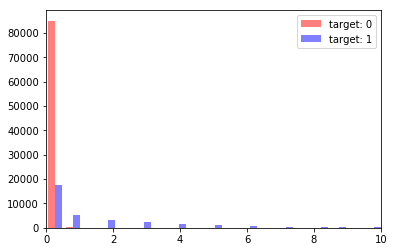

Histogram for trigram_question
                         count      mean       std  min  median   max
trigram_question (test)  74294  1.050166  1.895243  0.0     0.0  63.0


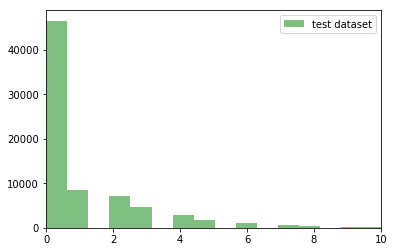

In [153]:
PlotHistByTarget(trainf.trigram_intersection, 'trigram_intersection', 0, 10, trainf, 'train')
PlotHistByTarget(testf.trigram_intersection, 'trigram_intersection', 0, 10, testf, 'test')

In [8]:
PlotHistByTarget(trainf.unq_qwords_rate, 'unq_qwords_rate', 0.5, 1, trainf, 'train')
PlotHistByTarget(testf.unq_qwords_rate, 'unq_qwords_rate', 0.5, 1, testf, 'test')

NameError: name 'PlotHistByTarget' is not defined

# Models

In [167]:
testf.columns

Index(['paragraph_id', 'question_id', 'paragraph', 'question', 'list_ratio',
       'list_intersections', 'len_paragraph', 'len_question',
       'len_intersection', 'cos_dist', 'min_ratio', 'max_ratio', 'std_ratio',
       'mean_ratio', 'num_sentences', 'min_inter', 'max_inter'],
      dtype='object')

In [157]:
columns = ['len_paragraph',
           'len_question',
           'len_intersection',
           'min_ratio',
           'max_ratio',
           'std_ratio',
           'mean_ratio',
           'num_sentences',
           'min_inter',
           'max_inter',
           'cos_dist',
           'bigram_intersection',
           'trigram_intersection'
          ]

## Gradient Boosting

In [158]:
model = GradientBoostingClassifier().fit(trainf[columns], trainf['target'])

In [159]:
feat_importance(model, columns)

NameError: name 'feat_importance' is not defined

In [211]:
testf['prediction'] = model.predict(testf[columns])

In [212]:
testf.head()

,paragraph_id,question_id,paragraph,question,list_ratio,list_intersections,len_paragraph,len_question,len_intersection,min_ratio,max_ratio,std_ratio,mean_ratio,num_sentences,min_inter,max_inter,prediction
0,1361,6463,"Ïåðåäíèé ìîçã ñèëüíî ðàçâèò, ýòî ñàìàÿ áîëüøàÿ...",Â êàêîé ìèôîëîãèè äâà âîðîíà Õóãèí è Ìóíèí øåï...,"[0.25, 0.17964, 0.16162, 0.02597, 0.1641, 0.13...","[0, 0, 2, 0, 1, 0, 1, 3, 0, 0, 0, 0, 0, 0]",113.0,14.0,3.0,0.00000,0.29834,0.090838,0.153921,14.0,0.0,3.0,0.0
1,1403,34696,Ìèðìåêîëîãè èññëåäóþò ìóðàâü¸â êàê â ëàáîðàòîð...,Êîãäà èíñàéäåð ïîêóïàåò èëè ãèïîòåçû ÷åãî ýâîë...,"[0.18265, 0.24409, 0.33696, 0.23077, 0.21017, ...","[0, 0, 5, 0, 0, 0]",79.0,11.0,5.0,0.18265,0.33696,0.048354,0.237508,6.0,0.0,5.0,1.0
2,1435,13751,Âîëíîâàÿ: ñâåò ïðåäñòàâëÿåò ñîáîé âîëíó â íåâè...,"Êàêèå ïðåäïîëîæåíèÿ, ïî ìíåíèþ Íüþòîíà, äîïóñò...","[0.23077, 0.17634, 0.33113]","[1, 3, 1]",63.0,12.0,3.0,0.17634,0.33113,0.064113,0.246080,3.0,1.0,3.0,0.0
3,341,38544,Æèâûå îðãàíèçìû ïîä÷èíÿþòñÿ íà÷àëàì òåðìîäèíàì...,Â êàêèõ óñëîâèÿõ ìåòàáîëèçì ïîääåðæèâàåò ïîðÿä...,"[0.32558, 0.29412, 0.17391, 0.27673, 0.33333, ...","[0, 0, 0, 1, 1, 9]",89.0,10.0,9.0,0.17391,0.89820,0.235975,0.383645,6.0,0.0,9.0,1.0
4,1317,14589,Ôàéëû íåëàòèíñêîãî òåêñòà â Þíèêîäå âñåãäà çàí...,Êàêèì ìåëîäèÿì Ïðîêîôüåâà îñîáåííî íå óêëàäûâà...,"[0.02812, 0.02824, 0.00893]","[8, 4, 4]",86.0,24.0,11.0,0.00893,0.02824,0.009075,0.021763,3.0,4.0,8.0,0.0


## Logistic Regression (unbalanced classes)

In [23]:
model_name = 'LogReg'

In [24]:
from sklearn.linear_model import LogisticRegression

balance_weight = 2.5071518
lr = LogisticRegression(class_weight={0: 1, 1: balance_weight})
#
lr.fit(trainf[columns],trainf['target'])
testf['prediction'] = lr.predict(testf[columns])

In [25]:
print(testf[testf['prediction'] == 0].shape[0]/testf[testf['prediction'] == 1].shape[0])
balance_weight = testf[testf['prediction'] == 0].shape[0]/testf[testf['prediction'] == 1].shape[0]

1.4160650406504065


In [26]:
print('-'*10,'max_inter > 15.0', '-'*10)
testf[testf.max_inter > 15.0]['prediction'].value_counts()

---------- max_inter > 15.0 ----------


1.0    327
0.0     10
Name: prediction, dtype: int64

In [27]:
testf[testf.min_inter > 10.0]['prediction'].value_counts()

1.0    39
0.0     7
Name: prediction, dtype: int64

In [28]:
testf[testf.mean_ratio < 0.02]['prediction'].value_counts()

0.0    370
1.0    221
Name: prediction, dtype: int64

In [31]:
submit(testf['prediction'],model_name+'2')

# XGBoost

In [32]:
columns = ['len_paragraph',
           'len_question',
           'len_intersection',
           'min_ratio',
           'max_ratio',
           'std_ratio',
           'mean_ratio',
           'num_sentences',
           #'min_inter',
           'max_inter',
           'cos_dist',
           'bigram_intersection',
           #'trigram_intersection',
           'unq_qwords_rate'
          ]

In [34]:
import xgboost as xgb

params ={
        'eta':0.02,
        'n_estimators': 1300,
        'max_depth': 7,
        'objective': 'binary:logistic',
        'eval_metric': 'auc'
        }

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(trainf[columns], trainf['target'], test_size=0.2)

do_validation = False

if do_validation:
    dtrain = xgb.DMatrix(X_train[columns], label = y_train)
    dvalid = xgb.DMatrix(X_valid[columns], label = y_valid)
    watchlist = [(dtrain, 'train'), (dvalid, 'train(test)')]
else:
    dtrain = xgb.DMatrix(X_train[columns], label = y_train)
    watchlist = [(dtrain, 'train')]

%time xgb_model = xgb.train(params = params, dtrain = dtrain, evals=watchlist, num_boost_round = params['n_estimators'], verbose_eval=100, early_stopping_rounds=100)

#xgboost.cv(params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None, metrics=(), obj=None, 
            #feval=None, maximize=False, early_stopping_rounds=None, fpreproc=None, as_pandas=True, 
            #verbose_eval=None, show_stdv=True, seed=0, callbacks=None)

#%time xgb_model = xgb.cv(params = params, dtrain = dtrain, num_boost_round = params['n_estimators'], metrics='auc', stratified=True, nfold=5, verbose_eval=100, early_stopping_rounds=100)

dtest = xgb.DMatrix(testf[columns])
#preds = xgb_model.predict(dtest)

testf['prediction'] = xgb_model.predict(dtest,ntree_limit=xgb_model.best_iteration)

[0]	train-auc:0.994243
Will train until train-auc hasn't improved in 100 rounds.
[100]	train-auc:0.996561
[200]	train-auc:0.997332
[300]	train-auc:0.997611
[400]	train-auc:0.997805
[500]	train-auc:0.998033
[600]	train-auc:0.998247
[700]	train-auc:0.998395
[800]	train-auc:0.998554
[900]	train-auc:0.998679
[1000]	train-auc:0.998825
[1100]	train-auc:0.99897
[1200]	train-auc:0.999075
Wall time: 1min 56s


In [12]:
#XGBC = xgb.XGBClassifier(max_depth=7, learning_rate=0.02, n_estimators=10000, silent=False, objective='binary:logistic', scale_pos_weight=2.5071518)

In [15]:
#XGBC.fit(trainf[columns], trainf['target'], eval_metric='auc', verbose=True)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=2.5071518, seed=0, silent=False, subsample=1)

In [16]:
#preds = XGBC.predict(testf[columns])

In [35]:
par = []
score = []
for k in xgb_model.get_fscore():
    par.append(k)
    score.append(xgb_model.get_fscore()[k])
res = pd.DataFrame({'variable':par,'split_counts':score})
res['importance'] = res['split_counts']/res['split_counts'].sum()
res.sort_values(by='importance',ascending=False)

,split_counts,variable,importance
2,8987,cos_dist,0.152059
1,7169,len_paragraph,0.121299
8,6389,mean_ratio,0.108101
4,6270,std_ratio,0.106088
6,6000,min_ratio,0.101519
0,5968,max_ratio,0.100978
11,5642,len_question,0.095462
10,3545,num_sentences,0.059981
3,3280,len_intersection,0.055497
5,2819,max_inter,0.047697


In [36]:
print(testf[testf['prediction'] < 0.5].shape[0]/testf[testf['prediction'] > 0.5].shape[0])

1.3363627787037329


In [40]:
submit(testf['prediction'],'XGB_210917_4')

In [13]:
lst11 = testf[testf['unq_qwords_rate']<0.5].question.index
pd.DataFrame({"vls": lst11.values}).to_csv('unq_qwords_rate_05.csv')

In [3]:
for ind in testf[testf['unq_qwords_rate']<0.5].question.index:
    testf[ind, 'prediction'] = 0.0

NameError: name 'testf' is not defined

In [468]:
testf.head()

,paragraph_id,question_id,paragraph,question,list_ratio,list_intersections,len_paragraph,len_question,len_intersection,cos_dist,...,max_ratio,std_ratio,mean_ratio,num_sentences,min_inter,max_inter,bigram_intersection,trigram_intersection,unq_qwords_rate,prediction
0,1361,6463,"Передний мозг сильно развит, это самая большая...",В какой мифологии два ворона Хугин и Мунин шеп...,"[0.25, 0.17964, 0.16162, 0.02597, 0.1641, 0.13...","[0, 0, 2, 0, 1, 0, 1, 3, 0, 0, 0, 0, 0, 0]",113.0,14.0,3.0,1.000000,...,0.29834,0.090838,0.153921,14.0,0.0,3.0,0.0,0.0,0.928571,0.000154
1,1403,34696,Мирмекологи исследуют муравьёв как в лаборатор...,Когда инсайдер покупает или гипотезы чего эвол...,"[0.18265, 0.24409, 0.33696, 0.23077, 0.21017, ...","[0, 0, 5, 0, 0, 0]",79.0,11.0,5.0,0.840197,...,0.33696,0.048354,0.237508,6.0,0.0,5.0,3.0,2.0,0.647059,0.468738
2,1435,13751,Волновая: свет представляет собой волну в неви...,"Какие предположения, по мнению Ньютона, допуст...","[0.23077, 0.17634, 0.33113]","[1, 3, 1]",63.0,12.0,3.0,0.963576,...,0.33113,0.064113,0.246080,3.0,1.0,3.0,0.0,0.0,1.000000,0.001953
3,341,38544,Живые организмы подчиняются началам термодинам...,В каких условиях метаболизм поддерживает поряд...,"[0.32558, 0.29412, 0.17391, 0.27673, 0.33333, ...","[0, 0, 0, 1, 1, 9]",89.0,10.0,9.0,0.684151,...,0.89820,0.235975,0.383645,6.0,0.0,9.0,6.0,5.0,1.000000,0.999754
4,1317,14589,Файлы нелатинского текста в Юникоде всегда зан...,Каким мелодиям Прокофьева особенно не укладыва...,"[0.02812, 0.02824, 0.00893]","[8, 4, 4]",86.0,24.0,11.0,0.691338,...,0.02824,0.009075,0.021763,3.0,4.0,8.0,3.0,2.0,0.888889,0.867975


In [38]:
for i in lst_qind:
    print(testf.prediction[i])

NameError: name 'lst_qind' is not defined

# Check

In [80]:
print('-'*10,'min_ratio > 0.4', '-'*10)
testf[testf.min_ratio>0.4]['prediction'].value_counts()

---------- min_ratio > 0.4 ----------


0.0    16
Name: prediction, dtype: int64

In [79]:
print('-'*10,'max_ratio > 0.9', '-'*10)
testf[testf.max_ratio > 0.9]['prediction'].value_counts()

---------- max_ratio > 0.9 ----------


0.0    231
Name: prediction, dtype: int64

In [93]:
print('-'*10,'max_ratio < 0.15', '-'*10)
testf[testf.max_ratio < 0.15]['prediction'].value_counts()

---------- max_ratio < 0.15 ----------


1.0    5021
0.0      62
Name: prediction, dtype: int64

In [83]:
print('-'*10,'std_ratio > 0.3', '-'*10)
testf[testf.std_ratio > 0.3]['prediction'].value_counts()

---------- std_ratio > 0.3 ----------


0.0    102
Name: prediction, dtype: int64

In [62]:
print('-'*10,'mean_ratio > 0.5', '-'*10)
testf[testf.mean_ratio > 0.5]['prediction'].value_counts()

---------- mean_ratio > 0.5 ----------


1.0    18
Name: prediction, dtype: int64

In [78]:
print('-'*10,'mean_ratio < 0.15', '-'*10)
testf[testf.mean_ratio < 0.15]['prediction'].value_counts()

---------- mean_ratio < 0.15 ----------


1.0    8814
0.0      86
Name: prediction, dtype: int64

In [77]:
print('-'*10,'min_inter > 10.0', '-'*10)
testf[testf.min_inter > 10.0]['prediction'].value_counts()

---------- min_inter > 10.0 ----------


0.0    46
Name: prediction, dtype: int64

In [76]:
print('-'*10,'max_inter > 15.0', '-'*10)
testf[testf.max_inter > 15.0]['prediction'].value_counts()

---------- max_inter > 15.0 ----------


0.0    337
Name: prediction, dtype: int64

In [69]:
#testf.loc[testf.min_ratio>0.4, 'prediction'] # = 1.0 # ok

In [70]:
#testf.loc[testf.max_ratio>0.9, 'prediction'] # = 1.0 # >0.85? ok

In [71]:
#testf.loc[testf.max_ratio<0.15, 'prediction'] # = 0.0 # ok

In [ ]:
#testf.loc[testf.std_ratio>0.3, 'prediction'] # = 1.0 # ok

In [ ]:
#testf.loc[testf.mean_ratio>0.5, 'prediction'] # = 1.0 # ok

In [ ]:
#testf.loc[testf.mean_ratio<0.15, 'prediction'] # = 0.0 # ok

In [ ]:
#test.loc[test.num_sentences>50, 'prediction'] = 1.0 # not available for test dataset

In [ ]:
#testf.loc[testf.min_inter>10, 'prediction'] # = 1.0 # ok

In [ ]:
#testf.loc[testf.max_inter>15, 'prediction'] # = 1.0 # ok

In [74]:
def SetTargetToTest(test):
    test.loc[test.min_ratio>0.4, 'prediction'] = float(int(1.0)^1) # ok
    test.loc[test.max_ratio>0.9, 'prediction'] = float(int(1.0)^1) # >0.85? ok
    test.loc[test.max_ratio<0.15, 'prediction'] = float(int(0.0)^1) # ok
    test.loc[test.std_ratio>0.3, 'prediction'] = float(int(1.0)^1) # ok
    test.loc[test.mean_ratio>0.5, 'prediction'] = float(int(1.0)^1) # ok
    test.loc[test.mean_ratio<0.15, 'prediction'] = float(int(0.0)^1) # ok
    #test.loc[test.num_sentences>50, 'prediction'] = 1.0)^1) # not available for test dataset
    test.loc[test.min_inter>10, 'prediction'] = float(int(1.0)^1) # ok
    test.loc[test.max_inter>15, 'prediction'] = float(int(1.0)^1) # ok

In [75]:
SetTargetToTest(testf)

In [173]:
submit(testf['prediction'],'LR_featset_cosdist')

# Feature Importance

In [274]:
def feat_importance(model, columns):
    features = pd.DataFrame()
    features['feature'] = columns
    features['importance'] = model.feature_importances_
    features.sort_values(by=['importance'], ascending=True, inplace=True)
    features.set_index('feature', inplace=True)
    
    features.plot(kind='barh', figsize=(20, 5))
    plt.show()

# Submit

In [168]:
def submit_inv(preds,model_name):
    res_frame = pd.DataFrame({"paragraph_id": testf.paragraph_id,
              "question_id": testf.question_id,
              "prediction": list(map(lambda x: 1.0 if x==0.0 else 0.0, list(preds.values)))})
    res_frame[['paragraph_id','question_id','prediction']].to_csv("PD_"+model_name+".csv", index=False)

In [30]:
def submit(preds,model_name):
    res_frame = pd.DataFrame({"paragraph_id": testf.paragraph_id,
              "question_id": testf.question_id,
              "prediction": preds.values})
    res_frame[['paragraph_id','question_id','prediction']].to_csv("PD_"+model_name+".csv", index=False)

# Test

# Test

In [52]:
#texts = trainf.paragraph[0]
texts = list(trainf.paragraph[:100])

In [53]:
wd = {}

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokens = [i.lower() for i in tokens if ( i not in string.punctuation+'—' )]
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на'])
    tokens = [i for i in tokens if ( i not in stop_words )]
    stems = []
    for item in tokens:
        if item in wd.keys():
            stems.append(wd[item])
        else:
            w = SnowballStemmer(language='russian').stem(item)
            wd[item] = w
            stems.append(w)
    return stems

In [54]:
vtr = CountVectorizer(tokenizer=tokenize)
%time vtr.fit(texts)
df_p = vtr.transform(trainf['paragraph'])
#df_q = vtr.transform(df['question'])
#dft_p = vtr.transform(dft['paragraph'])
#dft_q = vtr.transform(dft['question'])
print(df_p.shape,df_q.shape,dft_p.shape,dft_q.shape)

Wall time: 764 ms


KeyboardInterrupt: 

In [ ]:
df_p.head()

# Test

In [1]:
get_tokens(train.question[7])

NameError: name 'get_tokens' is not defined

In [2]:
finder = TrigramCollocationFinder.from_words(tokens, window_size=3)

NameError: name 'TrigramCollocationFinder' is not defined

In [48]:
finder.nbest(trigram_measures.pmi, 25)

[('использовал', 'разделения', 'народностей'),
 ('киевский', 'монах', 'нестор-летописец'),
 ('монах', 'нестор-летописец', 'использовал'),
 ('нестор-летописец', 'использовал', 'разделения'),
 ('признак', 'киевский', 'монах')]

In [49]:
sorted(finder.nbest(trigram_measures.raw_freq, 20))

[('использовал', 'разделения', 'народностей'),
 ('киевский', 'монах', 'нестор-летописец'),
 ('монах', 'нестор-летописец', 'использовал'),
 ('нестор-летописец', 'использовал', 'разделения'),
 ('признак', 'киевский', 'монах')]

In [34]:
scored = finder.score_ngrams(trigram_measures.raw_freq)
sorted(trigram for trigram, score in scored)

[('*', 'советские', 'пять'),
 ('*-xъ', 'праслав', '*čel-'),
 ('*ak', 'острый', '33'),
 ('*bh', '*dh', '*gh/ǰh'),
 ('*bʰ', '*dʰ', '*gʰ'),
 ('*dh', '*gh/ǰh', 'дальнейшем'),
 ('*dʰ', '*gʰ', 'арийск'),
 ('*gh/ǰh', 'дальнейшем', 'сохранившиеся'),
 ('*gʰ', 'арийск', '*bh'),
 ('*k', 'h', 'фонемизация'),
 ('*kh', 'арийск', '*p'),
 ('*krьst', '→', 'risti'),
 ('*lъžьka', '→', 'lusikka'),
 ('*mu-ntu', 'человек', 'суахили'),
 ('*ni-', '7', 'января'),
 ('*okъno', '→', 'akkuna'),
 ('*p', 'h', '*t'),
 ('*ph', '*th', '*kh'),
 ('*páad-', 'ссориться', 'именные'),
 ('*pád-', 'царапать', '*páad-'),
 ('*rey-', 'течь', 'бежать'),
 ('*reynos', 'корня', '*rey-'),
 ('*rīnaz', 'нему', 'восходят'),
 ('*t', 'h', '*k'),
 ('*th', '*kh', 'арийск'),
 ('*u̯eis-', 'течь', 'растекаться'),
 ('*verteno', '→', 'värttinä'),
 ('*vetъ', 'изречение', 'заве́т'),
 ('*visuria', 'северной', 'англии'),
 ('*čel-', 'отражённого', 'словах'),
 ('*čelověkъ', '*čelędь', 'внутренняя'),
 ('*čelędь', 'внутренняя', 'форма'),
 ('*два', 'минис

In [226]:
finder.nbest(bigram_measures.pmi, 25)

[('1035', 'Общероссийским', 'классификатором'),
 ('1653', 'Compendium', 'grammaticae'),
 ('1H', '2H', '3H'),
 ('Accipe', 'signaculum', 'doni'),
 ('Ara', 'Agrippinensium', 'Сокращённо'),
 ('Baess', 'Tassilo', 'Thierbach'),
 ('Biocam', 'Hughes', 'Duoscope'),
 ('Bronswiek', 'Brunswiek', 'Brönswiek'),
 ('Brunswiek', 'Brönswiek', 'ˈbrɔˑnsviːk'),
 ('Castorama', 'Media', 'Markt'),
 ('Chili', 'Peppers', 'Primus'),
 ('Compendium', 'grammaticae', 'Lithvanicae'),
 ('Cornelia', 'Veneria', 'Pompeianorum'),
 ('Det', 'Fri', 'Aktuelt'),
 ('Feligonde', 'Leopold', 'Ritter'),
 ('GBP', 'NOK', 'JPY'),
 ('Gadda', 'Da', 'Vida'),
 ('Greater', 'Winnipeg', 'Water'),
 ('He', 'Ne', 'Ar'),
 ('Hilton', 'Kempinski', 'Radisson'),
 ('Hughes', 'Duoscope', 'Movette'),
 ('Ich', 'habe', 'mit'),
 ('Junkers', 'Ju52', '3m'),
 ('Kempinski', 'Radisson', 'Swissôtel'),
 ('Kermer', 'Rolf', 'Osterreich')]

In [237]:
list(train.paragraph[:5].values)

['В отличие от рыб, земноводные (амфибии) и пресмыкающиеся (рептилии или гады) уже имеют два круга кровообращения и сердце у них трёхкамерное (появляется межпредсердная перегородка). Единственные современные рептилии, имеющие хотя и неполноценное (межпредсердиевая перегородка не полностью разделяет предсердия, что скорей всего связано с переходом предков к полуводному образу жизни и снижению активности), но уже четырёхкамерное сердце — крокодилы. Считается, что впервые четырёхкамерное сердце появилось у примитивных архозавров и развитых синапсидов. В дальнейшем такое строение сердца унаследовали прямые потомки динозавров — птицы и потомки примитивных млекопитающих — современные млекопитающие.',
 'В 1049 году Балдуину V удалось отнять у Германии часть Брабанта, которую потом называли Имперской Фландрией . Зато от Фландрии за это время отделились графы Камбрезский, Булонский, Сен-Поль и Гиньский. При Балдуине V авторитет графов Фландрских стоял во Франции очень высоко. Король Генрих I, у

In [ ]:
text = str(texts_upd)
tokens = nltk.wordpunct_tokenize(text)
finder = TrigramCollocationFinder.from_words(tokens)
finder.nbest(trigram_measures.pmi, 25)

In [240]:
scored = finder.score_ngrams(trigram_measures.raw_freq)
sorted(trigram for trigram, score in scored)

[('!', '(', '1962'),
 ('!', '(', 'Climax'),
 ('!', '(', 'Quiet'),
 ('!', '(', 'Харбин'),
 ('!', '(', 'намёк'),
 ('!', '(', 'первое'),
 ('!', '(', 'прибл'),
 ('!', '(', 'рус'),
 ('!', ')', 'Это'),
 ('!', ')', 'и'),
 ('!', '),', 'I'),
 ('!', '),', 'вышедший'),
 ('!', '),', 'но'),
 ('!', ').', 'Н'),
 ('!', ',', 'Ага'),
 ('!', ',', 'Да'),
 ('!', ',', 'Угу'),
 ('!', ',', 'в'),
 ('!', ',', 'и'),
 ('!', ',', 'она'),
 ('!', ',', 'расталкивая'),
 ('!', ',', 'совпадающее'),
 ('!', ',', 'столкновениями'),
 ('!', ',', '—'),
 ('!', '.', 'А'),
 ('!', '.', 'Она'),
 ('!', '.', 'Сибли'),
 ('!', '.', 'Тем'),
 ('!', ".',", "'"),
 ('!', '12', ','),
 ('!', '9', '('),
 ('!', 'Search', '['),
 ('!', 'Strawberry', 'Eggs'),
 ('!', 'You', 'Pretty'),
 ('!', '[', '113'),
 ('!', '[', '140'),
 ('!', '[', '22'),
 ('!', '[', '279'),
 ('!', '[', '39'),
 ('!', '[', '50'),
 ('!', 'nk', ','),
 ('!', 'Благовещенск', ','),
 ('!', 'В', 'августе'),
 ('!', 'В', 'конце'),
 ('!', 'Вероятно', ','),
 ('!', 'Вот', 'пришёл'),
 ('!',

In [401]:
id = 199
print('Q:')
print(testf.paragraph[id])
print('-'*50)
print('A:')
print(testf.question[id])
print('-'*50)
print('-'*50)

Q:
Хард-рок (англ. hard rock, дословно тяжелый рок или жёсткий рок) — жанр рок-музыки, характеризующийся выделенной ролью ритм-секции, главным образом бас-гитары и ударных инструментов. Композиции этого жанра часто построены на риффах в фигурах с размером 4/4. Хард-рок зародился в 1960-е годы, обрел привычные формы в конце 1960-х — начале 1970-х годов, а его расцвет пришёлся на начало 1970-х, при участии таких групп, как Led Zeppelin, Black Sabbath и Deep Purple. От хард-рока тут же ответвился хеви-метал, дав начало всей металлической музыке. Вторая его волна приходится на 1980-е годы (вслед за спадом популярности раннего панк-рока).
--------------------------------------------------
A:
Авторитетами какого жанра являются группы Led Zeppelin, Deep Purple, Black Sabbath?
--------------------------------------------------
--------------------------------------------------


In [402]:
testf.loc[id,'target'] = 0.0

In [403]:
testf[['paragraph_id', 'question_id', 'target']].to_csv('test_100plus.csv') 
 


In [404]:
pr = pd.read_csv('test_100minus.csv')

In [418]:
for i in range(100):
    testf.loc[i, 'target'] = pr.target[i]

In [419]:
testf.target[:200]

0      0.0
1      0.0
2      0.0
3      1.0
4      0.0
5      0.0
6      0.0
7      0.0
8      0.0
9      0.0
10     0.0
11     0.0
12     0.0
13     0.0
14     0.0
15     0.0
16     0.0
17     0.0
18     0.0
19     0.0
20     0.0
21     0.0
22     1.0
23     1.0
24     0.0
25     0.0
26     0.0
27     1.0
28     0.0
29     0.0
      ... 
170    0.0
171    0.0
172    1.0
173    0.0
174    0.0
175    0.0
176    0.0
177    0.0
178    0.0
179    0.0
180    0.0
181    0.0
182    0.0
183    0.0
184    0.0
185    0.0
186    0.0
187    0.0
188    0.0
189    1.0
190    0.0
191    0.0
192    0.0
193    0.0
194    0.0
195    0.0
196    0.0
197    0.0
198    0.0
199    0.0
Name: target, Length: 200, dtype: float64

In [420]:
testf[['paragraph_id', 'question_id', 'target']].to_csv('test_first200_marked.csv') 

# Test

In [8]:
import pandas as pd
train_t, test_t = pd.read_csv('train_tokens_facts_number.csv'), pd.read_csv('test_tokens_facts_number.csv')

In [4]:
train.head(2)

,paragraph,paragraph_id,question,question_id,target,train,tokens_paragraph,tokens_question,facts_paragraph,facts_question,cosine_distance,len_paragraph,len_question,len_intersection,len_intersection_rate,terms_paragraph,terms_question,terms_intersection,terms_intersection_rate
0,"В отличие от рыб, земноводные (амфибии) и прес...",1094,С какого года Русское Царство перешло на летои...,46273,0.0,1,"['в', 'отличие', 'от', 'рыба', 'земноводный', ...","['с', 'какой', 'год', 'русский', 'царство', 'п...","['сердце', 'четырёхкамерный сердце', 'рептилия...","['год', 'русский царство', 'какая год', '1 янв...",0.982397,64,19,4,0.210526,40,12,0,0.0
1,В 1049 году Балдуину V удалось отнять у Герман...,7414,Кто упомянул о его первых разногласиях со Штей...,19164,0.0,1,"['в', '1049', 'год', 'балдуин', 'v', 'удаться'...","['кто', 'упомянуть', 'о', 'он', 'один', 'разно...","['балдуин', 'сын', 'граф', 'фландрий', 'престо...","['подозрительный модернистский наклонность', '...",0.970422,78,29,4,0.137931,34,14,0,0.0


In [23]:
import ast
print(set(ast.literal_eval(train.tokens_paragraph[0])))

{'круг', 'переход', 'современный', 'синапсид', 'кровообращение', 'появляться', 'считаться', 'они', 'всего', 'снижение', 'неполноценный', 'что', 'четырёхкамерный', 'межпредсердиевый', 'жизнь', 'земноводный', 'от', 'хотя', 'млекопитающее', 'два', 'архозавр', 'динозавр', 'образ', 'предок', 'амфибия', 'полуводный', 'межпредсердный', 'связать', 'полностью', 'активность', 'строение', 'гад', 'пресмыкаться', 'появиться', 'в', 'дальнейший', 'уже', 'к', 'прямая', 'перегородка', 'иметь', 'с', 'отличие', 'единственный', 'сердце', 'впервые', 'предсердие', 'рыба', 'рептилия', 'развитый', 'или', 'у', 'разделять', 'потомок', 'примитивный', 'трёхкамерный', 'но', 'птица', 'скорый', 'такой', 'унаследовать', 'крокодил', 'не', 'и'}


In [24]:
len(set(ast.literal_eval(train.tokens_paragraph[0])))

64

In [25]:
print(set(ast.literal_eval(train.tokens_question[0])))

{'перейти', 'от', 'на', 'летоисчисление', 'рождество', 'новое', 'январь', 'а', 'сентябрь', 'год', 'и', '1', 'с', 'не', 'русский', 'какой', 'празднование', 'христов', 'царство'}


In [26]:
len(set(ast.literal_eval(train.tokens_question[0])))

19

In [27]:
len(set(ast.literal_eval(train.tokens_paragraph[0])+ast.literal_eval(train.tokens_question[0])))

79

In [28]:
len(set(ast.literal_eval(train.tokens_paragraph[0])+ast.literal_eval(train.tokens_question[0])))/len(set(ast.literal_eval(train.tokens_paragraph[0])))-1

0.234375

In [34]:
for i in range(50):
    print(i,
    round((len(set(ast.literal_eval(train.tokens_paragraph[i])+
            ast.literal_eval(train.tokens_question[i])))/
          len(set(ast.literal_eval(train.tokens_paragraph[i])))-1)*100,4)
    )

0 23.4375
1 32.0513
2 25.8621
3 17.7419
4 3.6145
5 20.9677
6 10.5263
7 3.0
8 1.25
9 9.2105
10 1.0101
11 15.7895
12 7.0423
13 10.8108
14 16.0377
15 3.0
16 6.6667
17 5.5046
18 28.169
19 7.8947
20 12.963
21 4.2857
22 3.6585
23 5.3571
24 8.4211
25 10.8434
26 15.942
27 2.7778
28 2.2472
29 18.0851
30 5.4054
31 3.2258
32 17.1053
33 17.7419
34 1.6667
35 15.2174
36 6.8966
37 1.4493
38 8.9888
39 1.7241
40 3.2258
41 16.6667
42 23.0769
43 6.5789
44 0.9174
45 2.9851
46 2.4691
47 11.8644
48 8.2192
49 1.0309


In [40]:
train.paragraph[10]

'Относительно нормативности использовании термина в форме пиксел либо пиксель имеются различные мнения. Так Русский орфографический словарь РАН [4] квалифицирует форму пиксел как общеупотребительную, а форму пиксель как характерную разговорной профессиональной или разговорной и профессиональной речи (в сокращениях словаря нет расшифровки для разг. проф. речи, но есть отдельно разг. — разговорное, проф. — профессиональное[5]; однозначной расшифровки этого определения не даёт и справочная служба русского языка на портале Грамота.ру[6]). С другой стороны, действующий ГОСТ 27459-87[7] предусматривает термин пиксель как единственно возможный для использования в области применения указанного стандарта (компьютерная графика) и который является обязательным для применения в документации и литературе всех видов, входящих в сферу действия стандартизации или использующих результаты этой деятельности . При этом ГОСТ 27459-87 под термином пиксель понимает наименьший элемент поверхности визуализации

In [41]:
train.question[10]

'Какую форму пиксел или пиксель Русский орфографический словарь РАН квалифицирует как характерную разговорной профессиональной или разговорной и профессиональной речи?'

In [41]:
ans = pd.read_csv('PD_XGB_220917_0.csv')

In [45]:
s_l, s_g = 0.0, 0.0

for ind in ans[test_t.len_percent>10.0].index:  # target: 0
    s_l += ans.loc[ind,'prediction']
    
for ind in ans[test_t.len_percent<2.5].index:  # target: 1
    s_g += ans.loc[ind,'prediction']

print(s_l, s_g)

2263.63658636 10584.4878296


In [46]:
for ind in test_t[test_t.len_percent>10.0].index: # target: 0
    ans.loc[ind,'prediction'] = 0.0
    
for ind in test_t[test_t.len_percent<2.5].index: # target: 1
    ans.loc[ind,'prediction'] = 1.0


In [47]:
ans[['paragraph_id', 'question_id', 'prediction']].to_csv('250917_lenpercent_10_2.5.csv') 

In [9]:
for name, df in [('train', train_t), ('test', test_t)]:
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total = df.shape[0], desc = "Adding len% for "+ name):
        df.loc[index, 'len_percent'] =  round((len(set(ast.literal_eval(row.tokens_paragraph)+
            ast.literal_eval(row.tokens_question)))/
          len(set(ast.literal_eval(row.tokens_paragraph)))-1)*100,4)

In [42]:
print(train_t[train_t.len_percent<2.5].shape[0]) # -> target: 1
print(train_t[train_t.len_percent<2.5].target.sum())

Int64Index([     8,     10,     28,     34,     37,     39,     44,     46,
                49,     55,
            ...
            119356, 119357, 119363, 119365, 119368, 119374, 119376, 119381,
            119385, 119388],
           dtype='int64', length=22470)


In [34]:
print(test_t[test_t.len_percent>10.0].shape[0]) # -> target: 0
#print(test_t[test_t.len_percent<2.5].target.sum())

23938


In [37]:
test_t[test_t.len_percent>10.0]

,paragraph,paragraph_id,question,question_id,target,train,tokens_paragraph,tokens_question,facts_paragraph,facts_question,cosine_distance,len_paragraph,len_question,len_intersection,len_intersection_rate,terms_paragraph,terms_question,terms_intersection,terms_intersection_rate,len_percent
0,"Передний мозг сильно развит, это самая большая...",1361,В какой мифологии два ворона Хугин и Мунин шеп...,6463,NaN,0,"['передний', 'мозг', 'сильно', 'развитый', 'эт...","['в', 'какой', 'мифология', 'два', 'ворон', 'х...","['часть', 'птица', 'мозг', 'передний мозг', 'с...","['какая мифология', 'два ворон', 'хугин', 'ухо...",0.992320,97,13,2,0.153846,54,9,0,0.000000,11.3402
2,Волновая: свет представляет собой волну в неви...,1435,"Какие предположения, по мнению Ньютона, допуст...",13751,NaN,0,"['волновой', 'свет', 'представлять', 'себя', '...","['какой', 'предположение', 'по', 'мнение', 'нь...","['теория', 'гюйгенс', 'волна', 'невидимый миро...","['натуральный философия', 'какая предположение...",0.955117,58,12,3,0.250000,28,7,1,0.142857,15.5172
4,Файлы нелатинского текста в Юникоде всегда зан...,1317,Каким мелодиям Прокофьева особенно не укладыва...,14589,NaN,0,"['файл', 'нелатинский', 'текст', 'в', 'юникод'...","['какой', 'мелодия', 'прокофьев', 'особенно', ...","['язык', 'символ', 'юникод', 'шрифт', 'файл', ...","['существенный мера', 'какая мелодия', 'язык',...",0.680274,74,24,12,0.500000,43,13,5,0.384615,16.2162
6,После этого из цифровых базовых матричных крис...,1282,Каким методом модель ЦП доводится до ума?,18076,NaN,0,"['после', 'это', 'из', 'цифровой', 'базовый', ...","['какой', 'метод', 'модель', 'цп', 'доводиться...","['процессор', 'цифровая базовый матричный крис...","['какая метод', 'цп', 'ум', 'модель', 'метод']",0.973665,55,7,1,0.142857,29,5,1,0.200000,10.9091
7,Хозяевами паразитических грибов чаще всего явл...,689,При какой рекомбинации у высших грибов диплоид...,19755,NaN,0,"['хозяин', 'паразитический', 'грибов', 'чаща',...","['при', 'какой', 'рекомбинация', 'у', 'высокий...","['хозяин', 'паразит', 'клетка', 'гриб', 'расте...","['диплоидный зиготический ядро', 'какая рекомб...",0.963420,127,17,4,0.235294,59,10,1,0.100000,10.2362
8,Аморальное деяние может обрести статус преступ...,1455,Когда деяние совершается в соответствующую уго...,36313,NaN,0,"['аморальный', 'деяние', 'мочь', 'обрести', 'с...","['когда', 'деяние', 'совершаться', 'в', 'соотв...","['опасность', 'норма', 'заражение', 'деяние', ...","['такая заболевание', 'правовая оценка', 'прав...",0.537226,60,26,16,0.615385,34,16,8,0.500000,16.6667
12,Особенно поразило меня в этих снежинках оригин...,1055,"Как называются виды снежных осадков, которые, ...",35277,NaN,0,"['особенно', 'поразить', 'я', 'в', 'этот', 'сн...","['как', 'называться', 'вид', 'снежный', 'осадо...","['снежинка', 'игла', 'диск', 'число', 'спица',...","['вид', 'снежный осадки', 'шарик', 'цикл', 'хл...",0.957412,66,18,6,0.333333,26,8,1,0.125000,18.1818
13,"Можно сказать, что первые языки программирован...",942,"Какой термин предполагает, что семантическая м...",14974,NaN,0,"['можно', 'сказать', 'что', 'один', 'язык', 'п...","['какой', 'термин', 'предполагать', 'что', 'се...","['язык', 'программирование', 'машина', 'соврем...","['семантический модель', 'какая термин', 'боль...",0.921013,82,16,4,0.250000,52,11,2,0.181818,14.6341
17,Для заключения брака необходимо достижение бра...,1597,"В России при согласии обоих супругов, не имеющ...",2581,NaN,0,"['для', 'заключение', 'брак', 'необходимый', '...","['в', 'россия', 'при', 'согласие', 'оба', 'суп...","['брак', 'страна', 'заключение', 'друг', 'неко...","['общий ребёнок', 'оба супруг', 'супруг', 'сог...",0.878353,50,13,4,0.307692,35,7,2,0.285714,18.0000
18,Языки Си и его потомок C++ являются небезопасн...,136,"Какой термин означает, что даже если программа...",10227,NaN,0,"['язык', 'си', 'и', 'он', 'потомок', 'c', 'явл...","['какой', 'термин', 'означать', 'что', 'даже',...","['программа', 'ошибка', 'язык', 'типизация', '...","['содержимый некий баг', 'некий б

In [39]:
test_t.paragraph[7]

'Хозяевами паразитических грибов чаще всего являются высшие растения, но ими могут быть и животные, а также грибы других видов. Для высасывания веществ из клетки хозяина на гифах паразитических грибов часто образуются гаустории, которые представляют собой боковые ответвления гифы, проникающие внутрь клетки хозяина. Паразиты проникают в тело хозяина через мелкие повреждения в его покровах, паразиты растений для этого используют естественные отверстия в эпидерме — устьица. В ходе роста гриб выделяет ферменты, разрушающие срединные пластинки между растительными клетками (пектиназы), в результате чего ткани размягчаются. Некоторые паразиты ограничиваются тем, что постепенно высасывают вещества из хозяина, но не приводят его к гибели, другие же выделяют ферменты, расщепляющие целлюлозу клеточной стенки, что приводит к гибели клетки-хозяина, после чего паразит питается органическими остатками хозяина. Некоторые грибы становятся паразитами только в определённых случаях. Например, известны вид

In [40]:
test_t.question[7]

'При какой рекомбинации у высших грибов диплоидное (зиготическое) ядро без периода покоя делится редукционно с образованием тетрады?'

In [17]:
train_t[train_t.target==1].shape[0]

34037

In [ ]:
train[train.len_percent<10.0].sum()/train[train.len_percent<10.0].shape[0]

In [ ]:
 round((len(set(ast.literal_eval(train.tokens_paragraph[i])+
            ast.literal_eval(train.tokens_question[i])))/
          len(set(ast.literal_eval(train.tokens_paragraph[i])))-1)*100,4)

Histogram for len_percent
                         count       mean       std  min   median       max
len_percent (target: 0)  85361  14.507889  8.883158  0.0  12.5000  134.3750
len_percent (target: 1)  34037   2.436988  1.939844  0.0   1.7857   22.6415


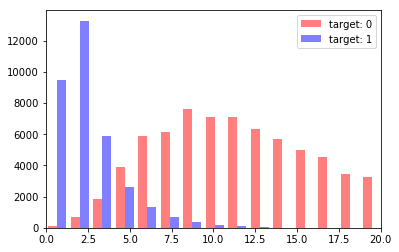

Histogram for len_percent
                    count      mean       std  min  median      max
len_percent (test)  74294  8.566644  6.998604  0.0  6.8966  81.8182


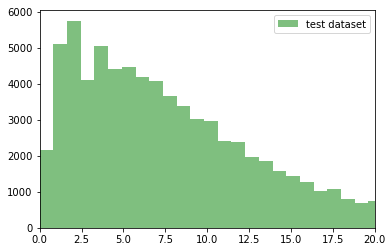

In [29]:
var_title = 'len_percent' 
PlotHistByTarget(train_t.len_percent, var_title, 0, 20, train_t, 'train')
PlotHistByTarget(test_t.len_percent, var_title, 0, 20, test_t, 'test')

# Test

In [181]:
train_ds, test_ds = pd.read_csv("train_task1_latest.csv"), pd.read_csv("test_task1_latest.csv")

In [77]:
text1 = train.loc[1].paragraph
text1

text2 = train.loc[2].paragraph
text2

'Стремление достичь предельных значений ёмкости для NAND-устройств привело к стандартизации брака — праву выпускать и продавать микросхемы с некоторым процентом бракованных ячеек и без гарантии непоявления новых bad-блоков в процессе эксплуатации. Чтобы минимизировать потери данных, каждая страница памяти снабжается небольшим дополнительным блоком, в котором записывается контрольная сумма, информация для восстановления при одиночных битовых ошибках, информация о сбойных элементах на этой странице и количестве записей на эту страницу.'

In [88]:
import re
from nltk import word_tokenize
st1 = set(word_tokenize(re.sub('[a-zA-Zа-яА-ЯёЁ]','',text1)))
st2 = set(word_tokenize(re.sub('[a-zA-Zа-яА-ЯёЁ]','',text2)))

In [86]:
st1 |=st2

In [102]:
st1.update(st2)

In [103]:
st1

{',', '-', '.', '1049', '—'}

In [111]:
stp = set(['.'])
stq = set(['.'])

for name, df in [('train', train), ('test', test)]:
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total=df.shape[0], desc="build dict for " + name):
        st_p = set(word_tokenize(re.sub('[a-zA-Zа-яА-ЯёЁ]','',row.paragraph)))
        stp.update(st_p)
        
        st_q = set(word_tokenize(re.sub('[a-zA-Zа-яА-ЯёЁ]','',row.question)))
        stq.update(st_q)

In [112]:
stp

{'+5,2',
 '1963—1964',
 '42,2',
 '396',
 '723',
 'ң',
 '223-',
 '2153',
 '1890—1903',
 '1994/95',
 '1988/89',
 '1211',
 '9000',
 '£60',
 '+0061',
 '.2',
 '-40',
 'ï',
 '357',
 '610',
 '七人の侍',
 '10−5',
 '1837—38',
 'ː',
 '1326',
 '716/718',
 '5,9',
 '1571',
 '1838',
 '1918—1929',
 '482',
 '23,712',
 '1540',
 '379',
 '22.',
 '1895—1896',
 '1,67·10⁻⁵3/2',
 '·1030',
 'πτερόν',
 '1360',
 '1270',
 '0,2',
 '2,1',
 '+19,9',
 '31,4',
 '−30…-33°',
 'γλία',
 'Στέφανος',
 '1999—2007',
 '4260',
 '50,3',
 '1712',
 '4—8',
 '1987',
 '-48',
 '232-',
 '6·10−23',
 '23*2',
 '„',
 '1,4',
 '9660',
 '5600',
 '14.03.2009',
 '1685',
 '229',
 '1751—1808',
 'τέρας',
 '1817',
 '38',
 '9,81',
 '1339',
 '10,44',
 '+40',
 '2003—2004',
 '1764—1784',
 '1912—1996',
 '−1…+10',
 '1947—1954',
 '1913',
 '1654',
 '10-20',
 '1127',
 '96',
 '86°',
 '464',
 '·10−9',
 '99,997',
 '770-',
 '16631018',
 '28,0',
 '7-8',
 '1816',
 '267',
 '1514',
 '1783',
 '2269',
 '1600',
 '2015',
 '1853',
 'ך',
 '72',
 '350—550',
 '46,6',
 '770',


In [113]:
stq

{'396',
 'ң',
 'เวียงจันทน์',
 '1988/89',
 '首',
 '1666',
 '.23',
 '9000',
 '1968-1980',
 '31,8',
 '1184',
 '4,3',
 '’',
 '1805',
 '-40',
 '1925',
 '1894',
 '1931',
 '1889',
 '1,20',
 '5,9',
 '1838',
 '1620',
 '1540',
 '!',
 '1,44',
 '1161',
 '1971—1973',
 '1991',
 '·1030',
 '07',
 '2008',
 '0,2',
 '2,1',
 '<',
 '239',
 '41',
 '493',
 '1712',
 '1987',
 '1,3',
 '²',
 '7',
 '23*2',
 '1657',
 '„',
 '1,4',
 '25',
 '12,00',
 '-93',
 '09',
 '1817',
 '1860—1880',
 '1878',
 '38',
 '21,8',
 '10,44',
 '1585—1590',
 '2003—2004',
 '87',
 '7,8',
 '1913',
 '1742',
 '88',
 '4725-1',
 '10-20',
 '1654',
 '29-',
 '96',
 '1827',
 '05',
 '1787',
 '136',
 '770-',
 '–',
 '1961—1991',
 '1772',
 '4:0',
 '1752',
 '1816',
 '70,5',
 '193',
 '1721',
 '28,0',
 'éé',
 '1902-1914',
 '1783',
 '1871',
 '16,00',
 '？）',
 '_4',
 '2015',
 '1853',
 '8879',
 '1,6',
 '1867-1872',
 '10,6',
 'å',
 '2,88',
 '72',
 '800-',
 '1933',
 '1979-1980',
 '0,51',
 '580',
 '313',
 '2.1',
 '1959',
 '1960—1962',
 'è',
 '5,5',
 '1961',
 '1822

In [118]:

D_except = {'(': ' '
            ,')': ' '
            ,'[': ' '
            ,']': ' '
            ,'{': ' '
            ,'}': ' '
            ,'&': ' '
            ,'@': ' '
            ,'#': ' '
            ,'$': ' '
            ,'%': ' '
            ,'№': ' '
            ,'*': ' '
            ,'—': ' '
            ,'\u0301': ''
            ,';': ' '
            ,':': ' '
            ,'/': ' '
            ,'\\': ' '
            ,'+': ' '
           }

for name, df in [('train', train), ('test', test)]:
    df.set_value(0,'list_ntokens_p',0)
    df.set_value(0,'list_ntokens_q',0)
    df['list_ntokens_p'] = df['list_ntokens_p'].astype(object)
    df['list_ntokens_q'] = df['list_ntokens_q'].astype(object)
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total=df.shape[0], desc="build norm tokens for " + name):
        df.set_value(index, 'list_ntokens_p', \
                     #[word_tokenize(morph.parse(t)[0].normal_form.replace('.','').replace(',','')) 
                     #for t in sent_tokenize(re.sub('.', lambda m: D_except.get(m.group(), m.group()), 
                     ''.join(YStem.lemmatize(re.sub('([\(\[]).*?([\)\]])',' ',row.paragraph))))#)])
        df.set_value(index, 'list_ntokens_q', \
                     #[word_tokenize(morph.parse(t)[0].normal_form.replace('.','').replace(',','')) 
                     #for t in sent_tokenize(re.sub('.', lambda m: D_except.get(m.group(), m.group()), 
                     ''.join(YStem.lemmatize(re.sub('([\(\[]).*?([\)\]])',' ',row.question))))#)])

KeyboardInterrupt: 

In [122]:
''.join(pm..lemmatize(re.sub('([\(\[]).*?([\)\]])',' ',train.loc[0].paragraph)))

['в',
 ' ',
 'отличие',
 ' ',
 'от',
 ' ',
 'рыба',
 ', ',
 'земноводный',
 '   ',
 'и',
 ' ',
 'пресмыкаться',
 '   ',
 'уже',
 ' ',
 'иметь',
 ' ',
 'два',
 ' ',
 'круг',
 ' ',
 'кровообращение',
 ' ',
 'и',
 ' ',
 'сердце',
 ' ',
 'у',
 ' ',
 'они',
 ' ',
 'трехкамерный',
 '  ',
 '. ',
 'единственный',
 ' ',
 'современный',
 ' ',
 'рептилия',
 ', ',
 'иметь',
 ' ',
 'хотя',
 ' ',
 'и',
 ' ',
 'неполноценный',
 '  , ',
 'но',
 ' ',
 'уже',
 ' ',
 'четырехкамерный',
 ' ',
 'сердце',
 ' — ',
 'крокодил',
 '. ',
 'считаться',
 ', ',
 'что',
 ' ',
 'впервые',
 ' ',
 'четырехкамерный',
 ' ',
 'сердце',
 ' ',
 'появляться',
 ' ',
 'у',
 ' ',
 'примитивный',
 ' ',
 'архозавр',
 ' ',
 'и',
 ' ',
 'развитый',
 ' ',
 'синапсид',
 '. ',
 'в',
 ' ',
 'дальнейший',
 ' ',
 'такой',
 ' ',
 'строение',
 ' ',
 'сердце',
 ' ',
 'унаследовать',
 ' ',
 'прямой',
 ' ',
 'потомок',
 ' ',
 'динозавр',
 ' — ',
 'птица',
 ' ',
 'и',
 ' ',
 'потомок',
 ' ',
 'примитивный',
 ' ',
 'млекопитающее',
 ' — ',
 'со

In [182]:
import pymorphy2 as pm

In [183]:
morph = pm.MorphAnalyzer()
morph.parse('рыб,')[0]

Parse(word='рыб,', tag=OpencorporaTag('UNKN'), normal_form='рыб,', score=1.0, methods_stack=((<UnknAnalyzer>, 'рыб,'),))

In [153]:
sent = re.sub('.', lambda m: D_except.get(m.group(), m.group()), train.loc[0].paragraph.replace(',',''))
sent_lst = sent.split()
lst = []
for i in range(len(sent_lst)):
    lst.append(''.join(morph.parse(sent_lst[i])[0].normal_form))
' '.join(lst)

'в отличие от рыба земноводный амфибия и пресмыкаться рептилия или гад уже иметь два круг кровообращение и сердце у они трёхкамерный появляться межпредсердный перегородка . единственный современный рептилия иметь хотя и неполноценный межпредсердиевый перегородка не полностью разделять предсердие что скорый всего связать с переход предок к полуводный образ жизнь и снижение активность но уже четырёхкамерный сердце крокодилы. считаться что впервые четырёхкамерный сердце появиться у примитивный архозавр и развитый синапсидов. в дальнейший такой строение сердце унаследовать прямая потомок динозавр птица и потомок примитивный млекопитающее современный млекопитающие.'

In [184]:
from nltk import sent_tokenize

In [249]:
for name, df in [('test', test_ds)]:
    df.set_value(0,'list_ntokens_p',0)
    df.set_value(0,'list_ntokens_q',0)
    df['list_ntokens_p'] = df['list_ntokens_p'].astype(object)
    df['list_ntokens_q'] = df['list_ntokens_q'].astype(object)
    for index, row in tqdm.tqdm_notebook(df.iterrows(), total=df.shape[0], desc="build norm tokens for " + name):
        par = re.sub('.', lambda m: D_except.get(m.group(), m.group()), re.sub('([\(\[]).*?([\)\]])',' ',row.paragraph.replace(',','')))
        par_lst = par.split()
        #print(par_lst)
        lst_p = []
        for i in range(len(par_lst)):
            lst_p.append(''.join(morph.parse(par_lst[i])[0].normal_form))
        list_ntokens_p = ' '.join(lst_p)
        df.set_value(index, 'list_ntokens_p', [word_tokenize(t.replace('.','')) for t in sent_tokenize(list_ntokens_p)])
        
        que = re.sub('.', lambda m: D_except.get(m.group(), m.group()), re.sub('([\(\[]).*?([\)\]])',' ',row.question.replace(',','')))
        que_lst = que.split()
        lst_q = []
        for i in range(len(que_lst)):
            lst_q.append(''.join(morph.parse(que_lst[i])[0].normal_form))
        list_ntokens_q = ' '.join(lst_q)
        df.set_value(index, 'list_ntokens_q', [word_tokenize(t.replace('.','')) for t in sent_tokenize(list_ntokens_q)])

24171/|/ 33%|| 24171/74294 [27:01<56:03, 14.90it/s]                                                                    


In [186]:
train.to_csv("250917_train_ntokens.csv", index=False, encoding ='utf-8')

In [250]:
test_ds.to_csv("250917_test_ntokens.csv", index=False, encoding ='utf-8')

In [198]:
test_ds.list_ntokens_q[0][-1][-1]

'одина'

In [201]:
test_ds.list_ntokens_q[1][-1].pop(-1)

'?'

In [235]:
for name, df in [('test', test_ds)]:
     for index, row in tqdm.tqdm_notebook(df.iterrows(), total=df.shape[0], desc="del ? sign for " + name):
            print(index)
            if row.list_ntokens_q[-1][-1] == "?":
                row.list_ntokens_q[-1].pop(-1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

IndexError: list index out of range

In [239]:
test_ds.question[366]

'Где обитает бабочка репейница ??'

In [245]:
D_except = {'(': ' '
            ,')': ' '
            ,'[': ' '
            ,']': ' '
            ,'{': ' '
            ,'}': ' '
            ,'&': ' '
            ,'@': ' '
            ,'#': ' '
            ,'$': ' '
            ,'%': ' '
            ,'№': ' '
            ,'*': ' '
            ,'—': ' '
            ,'\u0301': ''
            ,';': ' '
            ,':': ' '
            ,'/': ' '
            ,'\\': ' '
            ,'+': ' '
            ,'?': ' '
           }

que = re.sub('.', lambda m: D_except.get(m.group(), m.group()), re.sub('([\(\[]).*?([\)\]])',' ',test_ds.question[366].replace(',','')))
que_lst = que.split()
lst_q = []
for i in range(len(que_lst)):
    lst_q.append(''.join(morph.parse(que_lst[i])[0].normal_form))
    list_ntokens_q = ' '.join(lst_q)

In [246]:
list_ntokens_q

'где обитать бабочка репейница'

In [247]:
[word_tokenize(t.replace('.','')) for t in sent_tokenize(list_ntokens_q)]

[['где', 'обитать', 'бабочка', 'репейница']]